In [1]:
import torch
print(torch.cuda.is_available()) # should be True
# t = torch.rand(10, 10).cuda()
# print(t.device) # should be CUDA]
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torchio as tio
from typing import List, Tuple
from numpy import ndarray
from nilearn.image import resample_to_img
from sklearn.model_selection import StratifiedKFold
import torchio as tio
from nilearn.image import resample_to_img
from numpy import ndarray
from sklearn.model_selection import StratifiedKFold
import torchvision.transforms.functional as F
from torchvision.transforms import Compose
import random

/home/adil/Documents/TUE/preparationPhase/myProject/.conda/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


False


In [2]:
def various_distance(out_vec_t0, out_vec_t1,dist_flag):
    if dist_flag == 'l2':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=2)
    if dist_flag == 'l1':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=1)
    if dist_flag == 'cos':
        distance = 1 - F.cosine_similarity(out_vec_t0, out_vec_t1)
    return distance

import random

def balance_dataset(subject_images, label_key='label'):
    """
    Balances the dataset by undersampling the majority class to match the size of the minority class.
    
    Parameters:
    subject_images (list): List of dictionaries containing images and labels.
    label_key (str): Key used to access the label in the dictionaries.
    
    Returns:
    list: Balanced list of dictionaries.
    """

    similar_pairs = [x for x in subject_images if x[label_key] == 1]
    dissimilar_pairs = [x for x in subject_images if x[label_key] == 0]
    num_similar_pairs = len(similar_pairs)
    num_dissimilar_pairs = len(dissimilar_pairs)

    if num_similar_pairs > num_dissimilar_pairs:
        similar_pairs = random.sample(similar_pairs, num_dissimilar_pairs)
    else:
        dissimilar_pairs = random.sample(dissimilar_pairs, num_similar_pairs)
    balanced_subject_images = similar_pairs + dissimilar_pairs
    random.shuffle(balanced_subject_images)  # Shuffle to mix the pairs
    return balanced_subject_images

def stratified_kfold_split(dataset, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    splits = list(skf.split(range(len(dataset)), dataset.labels))
    return splits

def normalize_nifti(nifti_image: nib.Nifti1Image) -> ndarray:
    return (nifti_image.get_fdata() - np.min(nifti_image.get_fdata())) / (np.max(
        nifti_image.get_fdata()) - np.min(nifti_image.get_fdata()))

class ShiftImage:
    def __init__(self, max_shift_x=10, max_shift_y=10):
        self.max_shift_x = max_shift_x
        self.max_shift_y = max_shift_y
    def __call__(self, image):
        # Randomly shift the image
        shift_x = random.randint(-self.max_shift_x, self.max_shift_x)
        shift_y = random.randint(-self.max_shift_y, self.max_shift_y)
        
        # Shift the image using affine transformation
        return F.affine(image, angle=0, translate=(shift_x, shift_y), scale=1, shear=0)


def pad_slice(slice_2d: ndarray, output_size=(256, 256)) -> ndarray:
    """
    Pad a 2D slice to the desired output size with zeros.
    """
    pad_height = (output_size[0] - slice_2d.shape[0])
    pad_width = (output_size[1] - slice_2d.shape[1])
    
    padded_slice = np.pad(slice_2d, 
                          ((0, pad_height), (0, pad_width)), 
                          mode='edge')
    return padded_slice

def slice_has_high_info(slice_2d: np.ndarray, value_minimum=0.15, percentage_minimum=0.05):
    ## checks if the slice has high information by a certain value threshold and percentage of cells
    total_cells = slice_2d.size
    num_high_info_cells = np.count_nonzero(slice_2d >= value_minimum)
    percentage_high_info = num_high_info_cells / total_cells
    return percentage_high_info > percentage_minimum

def balance_classes_slices():
    return

def convert_3d_into_2d(nifti_image: ndarray, skip: int =1) -> list[Tuple[ndarray, Tuple[int, int, int]]]:
    slices = []
   
    # (axial)
    ## TODO: Use all slices for now only using every 4th slices
    for i in range(nifti_image.shape[0]):
        if i % skip == 0:
            slices.append((nifti_image[i, :, :], (i, -1 , -1)))
    #  (coronal)
    for i in range(nifti_image.shape[1]):
        if i % skip == 0:
            slices.append((nifti_image[:, i, :], (-1, i, -1)))  
    # (sagittal)
    for i in range(nifti_image.shape[2]):
        if i % skip == 0:
            slices.append((nifti_image[:, :, i], (-1, -1, i)))
    return slices

def has_tumor_cells(slice_2d: ndarray, threshold=0.15):
    ## checks if the slice has tumor cells by a certain value threshold
    return np.any(slice_2d >= threshold)

from scipy.ndimage import shift
def shift_image_numpy(image: np.ndarray, shift_amount: tuple, fill_value=0, mode='nearest') -> np.ndarray:
    """
    Shift an image using NumPy and fill the edges with the specified fill_value.
    
    Args:
        image (np.ndarray): Input 2D or 3D image array.
        shift_amount (tuple): Tuple indicating the amount to shift along each axis.
        fill_value (int, float, optional): Value to use for edge filling. Defaults to 0.
    
    Returns:
        np.ndarray: Shifted image with edges filled.
    """
    shifted_image = shift(image, shift=shift_amount, cval=fill_value, mode=mode)
    print(f"Shifted image shape: {shifted_image.shape}")
    return shifted_image

class ShiftImage:
    def __init__(self, max_shift_x=10, max_shift_y=10):
        self.max_shift_x = max_shift_x
        self.max_shift_y = max_shift_y

    def __call__(self, image):
        # Randomly shift the image
        shift_x = random.randint(-self.max_shift_x, self.max_shift_x)
        shift_y = random.randint(-self.max_shift_y, self.max_shift_y)
        
        # Shift the image using affine transformation
        return F.affine(image, angle=0, translate=(shift_x, shift_y), scale=1, shear=0)

    
from skimage.io import imread, imsave   


In [3]:
import torch.nn as nn
import torch
import numpy as np
import cv2
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def various_distance(out_vec_t0, out_vec_t1,dist_flag):
    if dist_flag == 'l2':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=2)
    if dist_flag == 'l1':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=1)
    if dist_flag == 'cos':
        distance = 1 - F.cosine_similarity(out_vec_t0, out_vec_t1)
    return distance

def merge_images(image1, image2, image3, output_path):
    # Create a new figure
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Display each image on a separate subplot
    axs[0].imshow(image1, cmap="gray")
    axs[0].axis('off')
    axs[1].imshow(image2, cmap="gray")
    axs[1].axis('off')
    im = axs[2].imshow(image3)
    axs[2].axis('off')
    
    # Create a colorbar
    cbar = plt.colorbar(im, ax=axs[2], orientation='vertical')
    cbar.set_label('Similarity Distance (Scaled by 255)')
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Save the merged image
    plt.savefig(output_path)
    plt.close(fig)
    
def generate_roc_curve(distances, labels, save_dir):
    # # Invert distances because lower distance indicates more similarity
    # distances = [d.cpu().item() for d in distances]
    # labels = [l.cpu().item() for l in labels]

    scores = [-d for d in distances]
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Save the plot to the specified directory
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'))
    plt.close()  # Close the plot to free up memory
    return thresholds
def single_layer_similar_heatmap_visual(output_t0,output_t1,dist_flag):
    print(output_t0.shape)
    interp = nn.Upsample(size=[512,512], mode='bilinear')
    c, h, w = output_t0.data.shape
    out_t0_rz = torch.transpose(output_t0.view(c, h * w), 1, 0)
    out_t1_rz = torch.transpose(output_t1.view(c, h * w), 1, 0)
    distance = various_distance(out_t0_rz,out_t1_rz,dist_flag=dist_flag)
    # print(distance)
    similar_distance_map = distance.view(h,w).data.cpu().numpy()
    similar_distance_map_rz = interp(torch.from_numpy(similar_distance_map[np.newaxis, np.newaxis, :]))
    # print(similar_distance_map_rz)
    similar_dis_map_colorize = cv2.applyColorMap(np.uint8(255 * similar_distance_map_rz.data.cpu().numpy()[0][0]), cv2.COLORMAP_JET)
    return similar_dis_map_colorize, out_t0_rz, out_t1_rz





In [23]:


class shifted_subject_patient_pairs(Dataset):
    def __init__(self, proc_preop: str, raw_tumor_dir: str, image_ids: list, save_dir: str, skip:int=1, tumor_sensitivity = 0.10, transform=None):
        self.root = proc_preop
        self.raw_tumor_dir = raw_tumor_dir
        self.transform = transform
        self.image_ids = image_ids
        self.save_dir = save_dir  # Directory to save 2D slices
        self.skip = skip
        self.tumor_sensitivity = tumor_sensitivity
        self.data = []

        os.makedirs(self.save_dir, exist_ok=True)  # Ensure the save directory exists
        
        for root, dirs, files in os.walk(self.root):
            for filename in files:
                for image_id in self.image_ids:
                    if filename.endswith(image_id):
                        try:
                            pat_id = root.split("/")[-1]
                            print(f"Processing {pat_id}")
                            preop_nifti = nib.load(os.path.join(root, filename))
                            postop_nifti = nib.load(os.path.join(root.replace("preop", "postop"), 
                                                                filename.replace("preop", "postop")))

                            if "PAT" in pat_id:
                                try:
                                    tumor = nib.load(os.path.join(f"{raw_tumor_dir}/{pat_id}/anat/{pat_id}_space_T1_label-tumor.nii"))
                                    tumor_resampled = resample_to_img(tumor, preop_nifti, interpolation='nearest')
                                    tumor_norm = normalize_nifti(tumor_resampled)
                                except FileNotFoundError:
                                    print(f"Tumor not found for {pat_id}")
                                    tumor_norm = None

                            # Normalize and resample preop and postop images
                            preop_nifti_norm = normalize_nifti(preop_nifti)
                            postop_nifti_norm = normalize_nifti(postop_nifti)

                            # Convert 3D images to 2D slices
                            images_pre = convert_3d_into_2d(preop_nifti_norm, skip=self.skip)
                            images_post = convert_3d_into_2d(postop_nifti_norm, skip=self.skip)

                            if "-CON" in pat_id:
                                self._process_con_slices(pat_id, images_pre, images_post)
                            elif "-PAT" in pat_id and tumor_norm is not None:
                                mask_slices = convert_3d_into_2d(tumor_norm, skip=self.skip)
                                self._process_pat_slices(pat_id, images_pre, images_post, mask_slices)
                            # return
                        except FileNotFoundError as e:
                            print(f"File not found: {e}")
                        except Exception as e:
                            print(f"Uncaught error: {e}")

    def _process_con_slices(self, pat_id, images_pre, images_post):
        """Process control patient (CON) slices and save them."""
        for i, (pre_slice, post_slice) in enumerate(zip(images_pre, images_post)):
            pre_path = self._save_slice(pre_slice[0], pat_id, i, 'pre', 1)
            post_path = self._save_slice(post_slice[0], pat_id, i, 'post', 1)
            if slice_has_high_info(pre_slice[0]) and slice_has_high_info(post_slice[0]):
                self.data.append({"pre_path": pre_path, "post_path": post_path, "label": 1, "pat_id": pat_id})

    def _process_pat_slices(self, pat_id, images_pre, images_post, mask_slices):
        """Process patient (PAT) slices and save them."""
        for i, (pre_slice, post_slice, mask_slice) in enumerate(zip(images_pre, images_post, mask_slices)):
            label = 0 if has_tumor_cells(mask_slice[0], threshold=self.tumor_sensitivity) else 1
            pre_path = self._save_slice(pre_slice[0], pat_id, i, 'pre', label)
            post_path = self._save_slice(post_slice[0], pat_id, i, 'post', label)
            tumor_path = self._save_slice(mask_slice[0], pat_id, i, 'tumor', label)
            if slice_has_high_info(pre_slice[0]) and slice_has_high_info(post_slice[0]):
                self.data.append({"pre_path": pre_path, "post_path": post_path, "tumor_path": tumor_path, "label": label, "pat_id": pat_id})

    def _save_slice(self, slice_array, pat_id, index, slice_type, label):
        """Save the 2D slice as a numpy file and return the file path."""
        filename = f"{pat_id}_slice_{index}_{slice_type}_label_{label}.npy"
        save_path = os.path.join(self.save_dir, filename)
        if not os.path.exists(save_path):
            np.save(save_path, slice_array)
        return save_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        triplet = self.data[idx]
        pre_slice = np.load(triplet["pre_path"])
        post_slice = np.load(triplet["post_path"])
        tumor_slice = np.load(triplet["tumor_path"]) if "tumor_path" in triplet else None

        # Apply any transformations if necessary
        if self.transform:
            pre_slice = self.transform(pre_slice)
            post_slice = self.transform(post_slice)
            # if tumor_slice is not None:
            #     tumor_slice = self.transform(tumor_slice)

        return {"pre": pre_slice, "post": post_slice, "label": triplet["label"], "tumor": tumor_slice}



In [24]:
import torchvision.transforms as T

subject_images = shifted_subject_patient_pairs(proc_preop='./../data/processed/preop/BTC-preop', 
            raw_tumor_dir='./../data/raw/preop/BTC-preop/derivatives/tumor_masks', save_dir='./../data/2D',
            image_ids=['t1_ants_aligned.nii.gz'], skip=80, tumor_sensitivity=0.15
            ,transform=Compose([
                    T.ToTensor(),
                    ShiftImage(max_shift_x=20, max_shift_y=20)]))
# balance subject_images based on label
print(f"Total number of image pairs signifcant : {len(subject_images)}")
# print("Number of similar pairs:", len([x for x in subject_images if x['label'] == 1]))
# print("Number of dissimilar pairs:", len([x for x in subject_images if x['label'] == 0]))
# _sub-PAT03___sagittal_102.jpg, around 90 -100
print(subject_images)
# subject_images_b = balance_dataset(subject_images)
# print(f"Total number of images after balancing: {len(subject_images_b)}")
# train_subject_images, val_subject_images, test_subject_images = random_split(subject_images_b, (0.6, 0.2, 0.2))

Processing sub-CON09
Processing sub-CON03
Processing sub-PAT25
Processing sub-PAT05
Processing sub-CON02
Processing sub-PAT26
Processing sub-PAT16
Processing sub-PAT01
Processing sub-PAT24
Processing sub-PAT13
Processing sub-CON06
Processing sub-PAT02
Processing sub-CON08
Processing sub-PAT10
Processing sub-CON04
Processing sub-PAT17
Processing sub-PAT07
Processing sub-CON11
Processing sub-CON07
Processing sub-PAT15
Processing sub-PAT08
Processing sub-CON10
Processing sub-PAT23
Processing sub-PAT20
Processing sub-PAT06
Processing sub-CON05
Processing sub-PAT03
Processing sub-PAT11
Processing sub-PAT28
Total number of images: 130


In [25]:
for i in subject_images:
    print(i.keys())
    break

dict_keys(['pre', 'post', 'label', 'tumor'])


In [26]:
subject_images_b = balance_dataset(subject_images)
# print(f"Total number of images after balancing: {len(subject_images_b)}")

In [28]:
train_subject_images, val_subject_images, test_subject_images = random_split(subject_images, (0.6, 0.2, 0.2))
print(f"Number of training images: {len(train_subject_images)}")
print(f"Number of validation images: {len(val_subject_images)}")
print(f"Number of testing images: {len(test_subject_images)}")

Number of training images: 78
Number of validation images: 26
Number of testing images: 26


sub-CON09
1


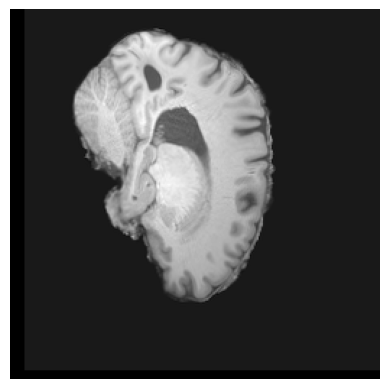

In [117]:
test = subject_images[2]
print(test['pat_id'])
print(test['label'])
# print(test['pre'])
# plt.imshow(test['pre'], cmap='gray')

# Plot the mask in red color with low opacity
# plt.imshow(test['pre'],cmap='gray')
#plt.imshow(test['post'], cmap='gray')
test['pre']: torch.Tensor
test['post']: torch.Tensor
plt.imshow(test['post'].cpu().numpy().squeeze(0), cmap='gray')
plt.axis('off')
plt.show()

### DIFF

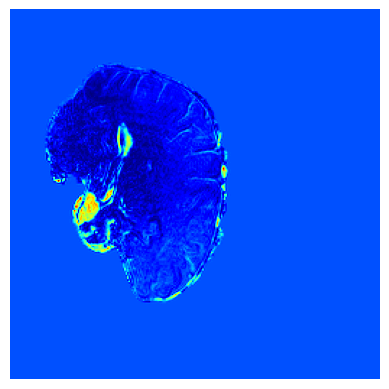

In [35]:
test['diff'] = np.abs(test['pre'] - test['post'])
plt.imshow(test['diff'], cmap='jet')
plt.axis('off')
plt.show()
# test['post'][255][255]

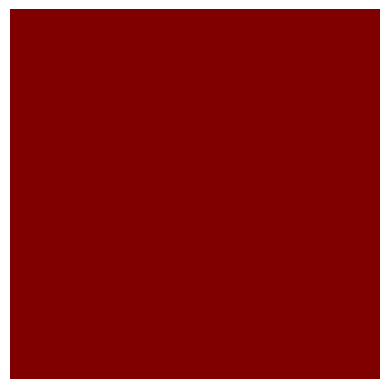

In [41]:
    # print(similar_distance_map_rz)
similar_dis_map_colorize = cv2.applyColorMap(np.uint8(test['diff']), cv2.COLORMAP_JET)
plt.axis('off')
plt.imshow(similar_dis_map_colorize)


## CHeck if slices match
### _sub-PAT03___sagittal_102.jpg, around 90 -100


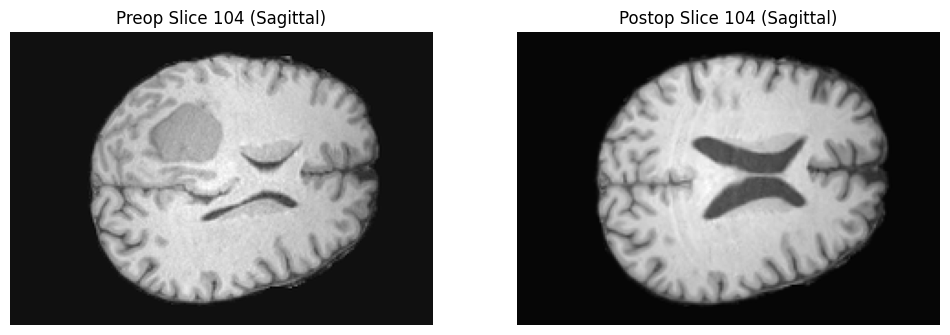

In [15]:
# Load the preop and postop NIfTI images for patient PAT03
pat_id = "sub-PAT03"
preop_nifti_path = f"./../data/processed/preop/BTC-preop/{pat_id}/t1_ants_aligned.nii.gz"
postop_nifti_path = f"./../data/processed/postop/BTC-postop/{pat_id}/t1_ants_aligned.nii.gz"
# data/processed/postop/BTC-postop/sub-PAT03/t1_ants_aligned.nii.gz
preop_nifti = nib.load(preop_nifti_path)
postop_nifti = nib.load(postop_nifti_path)

# Normalize the images
preop_nifti_norm = normalize_nifti(preop_nifti)
postop_nifti_norm = normalize_nifti(postop_nifti)

# Extract the sagittal slice 102
sagittal_slice_index = 104
preop_slice = preop_nifti_norm[:, :, sagittal_slice_index]
postop_slice = postop_nifti_norm[:, :, sagittal_slice_index]

# Plot the preop and postop slices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title(f"Preop Slice {sagittal_slice_index} (Sagittal)")
plt.imshow(preop_slice, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Postop Slice {sagittal_slice_index} (Sagittal)")
plt.imshow(postop_slice, cmap='gray')
plt.axis('off')

plt.show()

In [1]:
import pprint
torch.set_printoptions(threshold=torch.inf)

pprint.pprint(similar_dis_map_colorize)

NameError: name 'torch' is not defined

In [44]:
torch.set_printoptions(threshold=torch.inf)
np.set_printoptions(threshold=np.inf)  # Default setting
print(type(test['diff']))
print(test['diff'])
print(np.min(test['diff']))

<class 'numpy.ndarray'>
[[1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01

In [25]:
pre = torch.from_numpy(test['pre']).float().unsqueeze(1)
post = torch.from_numpy(test['post']).float().unsqueeze(1)
heatmap, out1_trans, out2_trans = single_layer_similar_heatmap_visual(pre, post, 'l2')


torch.Size([256, 1, 256])


sub-PAT25
0


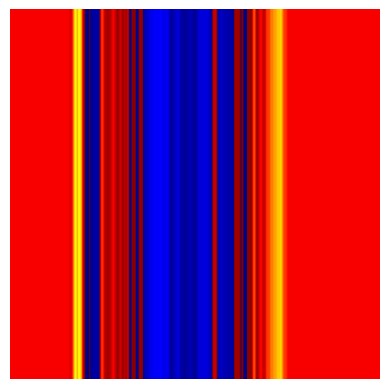

In [26]:
test = subject_images[3]
test['index_pre']
print(test['pat_id'])
print(test['label'])
# print(test['pre'])
plt.imshow(heatmap)

# Plot the mask in red color with low opacity
# plt.imshow(test['tumor'],cmap='Reds', alpha=0.6)
#plt.imshow(test['post'], cmap='Reds', alpha=0.3)
# Show the plot
plt.axis('off')
plt.show()

In [54]:
print(test['pre'].max())

0.6946996872360465
